In [ ]:
# notebook for looking at length histogram differences for generated outputs

In [1]:
from rlhfutils.eval_utils import oai_kwargs, load_alldfs, annotate_apfarm, apf_format, load_wgpt, filter_and_sort_df
import pandas as pd
from statistics import mean, stdev
import matplotlib.pyplot as plt
import re
from transformers import AutoTokenizer
from datasets import load_dataset
import openai
from rlhfutils.data import qaform
from transformers import AutoTokenizer
import pandas as pd
from rlhfutils.eval_utils import getapfsft, tok_dist
import matplotlib.pyplot as plt
from rlhfutils.debug_utils import load_rm, progress_rm
import argparse
import nltk
from nltk.tokenize import sent_tokenize
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

/home/prasann/miniconda3/envs/stackenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasann/miniconda3/envs/stackenv/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


[2023-09-28 09:16:05,844] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /home/prasann/miniconda3/envs/stackenv/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/prasann/miniconda3/envs/stackenv/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/prasann/miniconda3/envs/stackenv/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/prasann/miniconda3/envs/stackenv/lib/libcudart.so.11.0'), PosixPath('/home/prasann/miniconda3/envs/stackenv/lib/libcudart.so')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
toker = AutoTokenizer.from_pretrained("../webgpt-llama/models/sft10k")

In [ ]:
print(adfs.keys())

In [7]:
# given a dataframe, use rm to get rmscos if it doesn't already have them. 
# then bin / mean at intervals of 10 tokens and return lists for a scatter
def score_rm(indf, rm):
    indf['qstrs'] = [qaform(r['question'], r['response']) for _, r in indf.iterrows()]
    rewards = progress_rm(list(indf['qstrs']), rm, kwargs)
    scos = [a[0]['score'] for a in rewards]
    indf['rewards'] = scos

In [31]:
def fancyscatter(k1, k2, title, dfs):
    # Generate three datasets:
    # 1. For the scatter plot
    x_scatter = list(range(0, 300, 10))
    sfthist = dfs[k1].rcnt
    ppohist = dfs[k2].rcnt

    sftscatter, scv = binscatter(dfs[k1])
    pposcatter, pcv = binscatter(dfs[k2])

    diffs = []
    tval = sum([s for s in scv if s is not None])+sum([s for s in pcv if s is not None])
    for i in range(len(sftscatter)):
        if sftscatter[i]!=None and pposcatter[i]!=None:
            diffs.append((pposcatter[i]-sftscatter[i])*((scv[i]+pcv[i])/tval))
    print(sum(diffs))
    # Create a figure and a grid of subplots using GridSpec
    #fig = plt.figure(figsize=(8,4))
    fig = plt.figure(figsize=(16,8))
    fig.suptitle(title, fontsize=16)

    gs = gridspec.GridSpec(16, 8, wspace=0.0, hspace=0.0)
    
    scatter_ax = plt.subplot(gs[:, :])
    #right_hist_ax = plt.subplot(gs[:, 9:], sharey=scatter_ax)
    #y_hist_ax = plt.subplot(gs[:, 0], sharey=right_hist_ax)

    # Remove tick labels for the histograms as they share axes with scatter plot
    #y_hist_ax.xaxis.set_ticklabels([])
    #y_hist_ax.invert_xaxis()
    #right_hist_ax.xaxis.set_ticklabels([])
    #right_hist_ax.yaxis.set_ticklabels([])  # only remove y tick labels for the right histogram
    #right_hist_ax.yaxis.tick_right()

    # Hide y-axis of scatter plot
    #scatter_ax.yaxis.set_visible(False)
    
    # Ensure y-axis of y_hist_ax is visible (this ensures y-axis labels are displayed)
    #y_hist_ax.yaxis.set_visible(True)
    # scatter_ax.set_xlim(min([n for n in sftscatter if n is not None]), max([n for n in pposcatter if n is not None]))
    # Plot the scatter plot and histograms
    scatter_ax.scatter(x_scatter, sftscatter, color='#0F4392')
    scatter_ax.scatter(x_scatter, pposcatter, color='#FF5151')
    #y_hist_ax.hist(sfthist, bins=15, orientation='horizontal', color='#000249', alpha=0.7)
    #right_hist_ax.hist(ppohist, bins=15, orientation='horizontal', color='#FF8B8B', alpha=0.7)

    return fig

In [9]:
rlcdnames = ['rlcdsftv3', 'rlcdorigv3', 'rlcdhkl']
stacknames = ['stacksft', 'stackorigrerun', 'stackhkl']
wgptnames = ['wgptsft', 'wgptppoorig', 'wgpthkllate']

0.1162372328192641


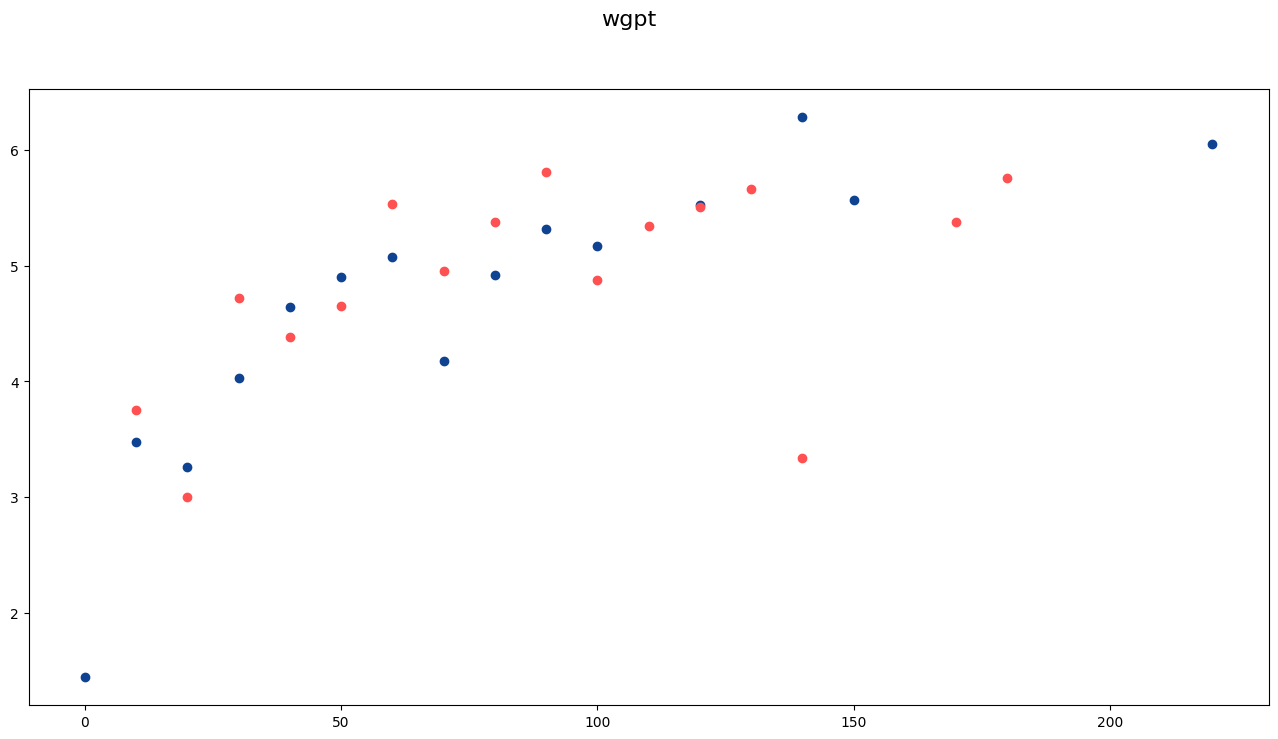

In [65]:
f = fancyscatter(rlcdnames[0], rlcdnames[2], 'wgpt', rlcds)

0.37186302430995694


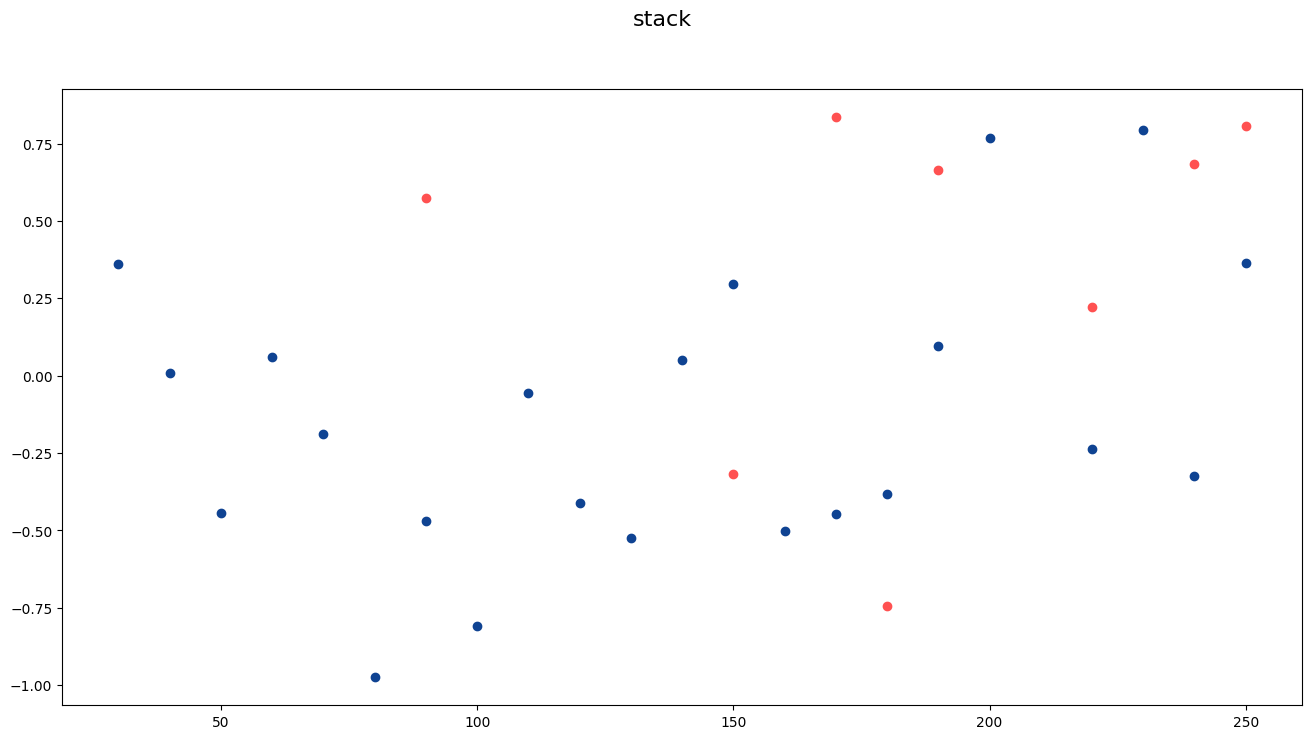

In [61]:
f = fancyscatter(stacknames[0], stacknames[2], 'stack', stacks)

0.016698400728896647


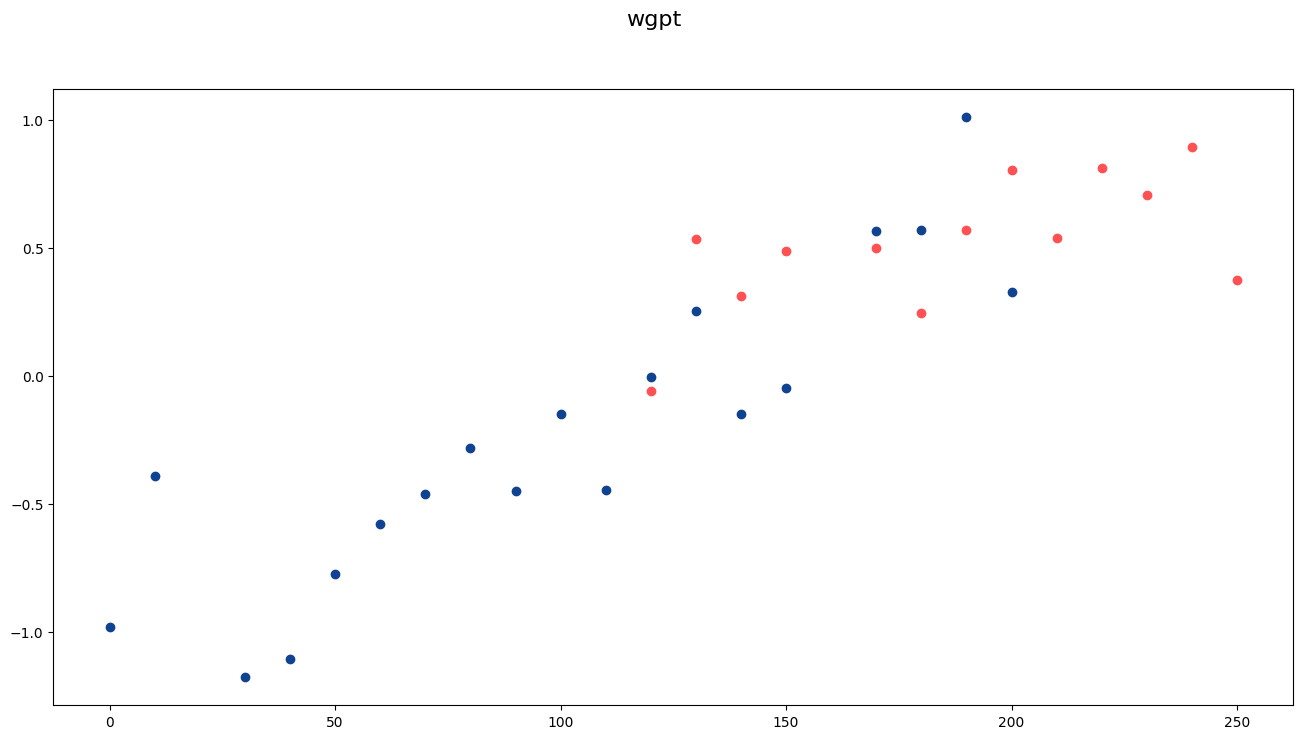

In [63]:
f = fancyscatter(wgptnames[0], wgptnames[1], 'wgpt', wgs)

In [ ]:
f = fancyscatter('rlcdsftv3', 'rlcdhkl', 'RLCD', rlcds)

In [54]:
wgs = load_alldfs("../trl-general/genouts/wgpt//", 400, False)
rlcds = load_alldfs("../trl-general/genouts/rlcdfix///", 400, False)
stacks = load_alldfs("../trl-general/genouts/stack/", 400, False)

generated_wgptnokl.jsonl
generated_wgptmix50_end.jsonl
generated_wgptveryrand.jsonl
generated_wgpt4gpu75.jsonl
generated_webgptdappov2125.jsonl
generated_wgptthrowlong.jsonl
generated_wgpt4gpu150.jsonl
generated_wgptthrowlong75.jsonl
generated_rlcdtruncboth.jsonl
generated_wgptnewppo.jsonl
generated_rlcdtruncbad.jsonl
generated_wgpthklearly.jsonl
generated_wgpthkllate.jsonl
generated_wgptboth.jsonl
generated_wgptmix50_highkl.jsonl
generated_wgptppoorig.jsonl
generated_wgptlenbal.jsonl
generated_wgptrwscale.jsonl
generated_wgptsft.jsonl
generated_webgptdappo.jsonl
generated_wgptgoodcut.jsonl
generated_wgptonew.jsonl
generated_wgptlenonly.jsonl
generated_webgptdappov250.jsonl
davinciwebgpt.jsonl
generated_wgptlencons.jsonl
generated_rlcdnokl.jsonl
generated_rlcdbalancerm.jsonl
generated_rlcdgoodcut.jsonl
generated_rlcdhkl.jsonl
generated_rlcddiagcut.jsonl
generated_rlcdmidcutfix.jsonl
generated_rlcdlenpen.jsonl
generated_rlcdrwscale.jsonl
generated_rlcdleftonly.jsonl
generated_rlcdlenonl

In [58]:
wgs['wgpthkllate']

,question,response,wcnt,rcnt
0,How do our bodies produce heat?\n\nWe have a c...,Our body produces heat through two main proces...,51,100
1,"if brain has no pain receptors, why do headach...",Headaches can be caused by many different fact...,22,106
2,How is it that humans advanced more rapidly ba...,The relative advancement of different human po...,45,107
3,"Why do we call herbal water ""Tea""?",The term “tea” comes from the Chinese word for...,12,92
4,Why do colleges in the United States have such...,The main reason why college costs vary so grea...,134,185
...,...,...,...,...
163,British Cockney rhyming slang\n\nIt doesn't ab...,Cockney Rhyming Slang is a form of slang used ...,65,143
164,the whole gene-edited babies that were born in...,The birth of edited baby cells in China has si...,34,128
165,If alcohol and marijuana are both believed to ...,Alcohol and marijuana both activate endocannab...,29,144
166,Why do we still use CPUs if graphic cards are ...,We continue to rely on central processing unit...,53,67


In [ ]:
wgdf = pd.DataFrame({
    'sftlen':list(wgs['wgptsft'].rcnt),
    'origlen':list(wgs['wgptppoorig'].rcnt)
})
rlcdldf = pd.DataFrame({
    'sftlen':list(rlcds['rlcdsftv3'].rcnt),
    'origlen':list(rlcds['rlcdorigv3'].rcnt)
})
stackldf = pd.DataFrame({
    'sftlen':list(stacks['stacksft'].rcnt),
    'origlen':list(stacks['stackorigrerun'].rcnt)
})

In [ ]:
wgdf.to_json("wgptlens.json")
rlcdldf.to_json("rlcdlens.json")
stackldf.to_json('stacklens.json')

In [ ]:
pd.read_json('stacklens.json')

In [48]:
len(wgs['wgpthkllate'])

102

In [44]:
# webgpt get stuff for figures
#adfs = load_alldfs("../trl-general/genouts/wgpt//")
tok, rm, kwargs = load_rm("/mnt/data1/prasann/rlhf-exploration/webgpt-llama/models/rewardmodel", 0)
# score_dfs = ['wgptrwscale', 'wgptsft', 'wgptppoorig', 'wgpthkllate', 'wgptthrowlong']
score_dfs = ['wgptsft', 'wgptppoorig', 'wgpthkllate']
for s in score_dfs:
    score_rm(wgs[s], rm)

  0%|                                                                                                                                          | 0/7 [00:00<?, ?it/s]/home/prasann/miniconda3/envs/stackenv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
  0%|                                                                                                                                          | 0/7 [00:00<?, ?it/s]/home/prasann/miniconda3/envs/stackenv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality 

In [ ]:
adfs = load_alldfs("../trl-general/genouts/stack/")

In [ ]:
def bothhists(sdf, edf):
    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(16, 16, wspace=0.0, hspace=0.0)
    orig_ax = plt.subplot(gs[:8, :])
    scatter_ax = plt.subplot(gs[8:, :], sharex=orig_ax)
    orig_ax.hist(sdf.rcnt, color='b')
    scatter_ax.hist(edf.rcnt, color='r')
    return fig

In [ ]:
# stack get stuff for figures
tok, rm, kwargs = load_rm("/mnt/data1/prasann/rlhf-exploration/stack-llama/models/rewardsanity/", 0)
#adfs = load_alldfs("../trl-general/genouts/stack/")
score_dfs = ['stacksft', 'stackorigrerun', 'stackhkl']
for s in score_dfs:
    score_rm(stacks[s], rm)

In [ ]:
# rlcd get stuff for figures
tok, rm, kwargs = load_rm("/mnt/data1/prasann/rlhf-exploration/rlcd-llama/models/rlcdnormal/", 0)
adfs = load_alldfs("../trl-general/genouts/rlcdfix/")
score_dfs = ['rlcdsftv3', 'rlcdorigv3', 'rlcdhkl']
for s in score_dfs:
    score_rm(rlcds[s], rm)

In [ ]:
rlcdnames = ['rlcdsftv3', 'rlcdorigv3', 'rlcdhkl']
stacknames = ['stacksft', 'stackorigrerun', 'stackhkl']
wgptnames = ['wgptsft', 'wgptppoorig', 'wgpthkllate']


In [ ]:
f = fancyscatter('rlcdsftv3', s, 'RLCD')

In [ ]:
for s in score_dfs:
    if 'sft' in s:
        continue
    f = fancyscatter('rlcdsftv3', s, 'RLCD')
    plt.savefig(s+".pdf", format="pdf", bbox_inches="tight")

In [ ]:
for s in score_dfs:
    if 'sft' in s:
        continue
    f = fancyscatter('rlcdsftv3', s, 'RLCD')
    plt.savefig(s+".pdf", format="pdf", bbox_inches="tight")

In [ ]:
for s in score_dfs:
    if 'sft' in s:
        continue
    f = fancyscatter('wgptsft', s, 'WebGPT')
    plt.savefig(s+".pdf", format="pdf", bbox_inches="tight")

In [ ]:
for s in score_dfs:
    if 'sft' in s:
        continue
    f = fancyscatter('stacksft', s, 'Stack')
    plt.savefig(s+".pdf", format="pdf", bbox_inches="tight")

In [ ]:
adfs = load_alldfs("../trl-general/genouts/rlcdfix//")

In [ ]:
a = bothhists(adfs['rlcdsftv3'], adfs['rlcdorigv3'])
plt.savefig("rlcddistcomp.pdf", format="pdf", bbox_inches="tight")

In [ ]:
plt.hist(adfs['wgptppoorig'][])

In [ ]:
plt.hist(adfs['wgptppoorig']['rcnt'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
#x = np.array([1, 2, 3, 4, 5])
#red_y = np.array([5, 3, 8, 6, 7])
#blue_y = np.array([4, 4, 6, 5, 9])

def overlap_vis(x, ry, by, intl):   
    plt.figure(figsize=(10, 6))
    plt.scatter(x, ry, color='red', label='Red Points')
    plt.scatter(x, by, color='blue', label='Blue Points')
    
    for i in range(1, len(x)):
        x_triangle = [x[i - 1], x[i], x[i]]
        
        # When red is above blue
        if ry[i] > by[i]:
            y_triangle = [min(by[i - 1], ry[i-1]), by[i], ry[i]]
            plt.fill(x_triangle, y_triangle, color='red', alpha=intl[i]/sum(intl))
        
        # When blue is above or equal to red
        else:
            y_triangle = [min(ry[i - 1], by[i-1]), ry[i], by[i]]
            plt.fill(x_triangle, y_triangle, color='blue', alpha=intl[i]/sum(intl))
    
    #plt.plot(x, red_y, color='red', alpha=0.5)
    #plt.plot(x, blue_y, color='blue', alpha=0.5)
    plt.legend()
    plt.title("Red vs. Blue Points with Triangular Fill")
    plt.xlabel("X-values")
    plt.ylabel("Y-values")
    plt.show()


import matplotlib.pyplot as plt

def overlap_vis(x, ry, by, intlist, col):   
    
    # plt.scatter(x, ry, color='red', label='Red Points')
    plt.scatter(x, by, color=col)
    
    for i in range(len(x)):
        alpha_intensity = intlist[i]
        
        # Calculate arrow properties
        dx = 0  # no horizontal movement
        dy = ry[i] - by[i]  # vertical distance between blue and red
        
        # Draw the arrow
        #plt.arrow(x[i], by[i], dx, dy, head_width=2, head_length=0.05, fc=arrow_color, ec=arrow_color, alpha=0.2)
        plt.arrow(x[i], by[i], dx, dy, head_width=2, head_length=0.05, fc=col, ec=col, alpha=min(1, alpha_intensity*5/sum(intlist)))
    
    #plt.legend()
    #plt.title("WGPT")
    #plt.xlabel("Length")
    #plt.ylabel("Rewarrd")
    #plt.show()

In [35]:
def fancyscatter(k1, k2, k3, title, dfs):
    # Generate three datasets:
    # 1. For the scatter plot
    x_scatter = list(range(0, 300, 10))
    sfthist = dfs[k1].rcnt
    ppohist = dfs[k2].rcnt

    sftscatter, scv = binscatter(dfs[k1])
    pposcatter, pcv = binscatter(dfs[k2])
    lsscatter, lcv = binscatter(dfs[k3])

    
    diffs = []
    ldiffs = []
    tval = sum([s for s in scv if s is not None])+sum([s for s in pcv if s is not None])
    for i in range(len(sftscatter)):
        if sftscatter[i]!=None and pposcatter[i]!=None:
            diffs.append((pposcatter[i]-sftscatter[i])*((scv[i]+pcv[i])/tval))
        if sftscatter[i]!=None and lsscatter[i]!=None:
            ldiffs.append((lsscatter[i]-sftscatter[i])*((scv[i]+lcv[i])/tval))
            
    print(sum(diffs))
    print(sum(ldiffs))
    nsft = []
    nppo = []
    lsft = []
    lppo = []
    lx = []
    nx = []
    ints = []
    lints = []
    for i in range(len(pposcatter)):
        if pposcatter[i]!=None and sftscatter[i]!=None:
            nsft.append(sftscatter[i])
            nppo.append(pposcatter[i])
            nx.append(x_scatter[i])
            ints.append((scv[i]+pcv[i]))
        if sftscatter[i]!=None and lsscatter[i]!=None:
            lsft.append(sftscatter[i])
            lppo.append(lsscatter[i])
            lx.append(x_scatter[i]+4)
            lints.append((scv[i]+lcv[i]))
    plt.figure(figsize=(10, 6))
    overlap_vis(nx, nppo, nsft, ints, 'red')
    overlap_vis(lx, lppo, lsft, lints, 'black')
    

In [26]:
import pickle

In [60]:
with open('wgptdata.pkl', 'rb') as f:
    wgs = pickle.load(f)
with open('rlcddata.pkl', 'rb') as f:
    rlcds = pickle.load(f)
with open('stackdata.pkl', 'rb') as f:
    stacks = pickle.load(f)

In [41]:
def binscatter(indf):
    mvals = []
    cntvals = []
    for i in range(0, 300, 15):
        tmp = indf[(indf.rcnt>i)&(indf.rcnt<i+15)].copy()
        if len(tmp)>1:
            mvals.append(tmp.rewards.mean())
            cntvals.append(len(tmp))
        else:
            mvals.append(None)
            cntvals.append(None)
    return mvals, cntvals

def compscatter(k1, k2):
    xrange = list(range(0, 300, 10))
    ysft = binscatter(adfs[k1])
    yppoorig = binscatter(adfs[k2])
    diffdist = []
    for i in range(len(ysft)):
        if ysft[i]!=None and yppoorig[i]!=None:
            diffdist.append(yppoorig[i]-ysft[i])
    plt.scatter(xrange, ysft, c='blue')
    plt.scatter(xrange, yppoorig, c='red')
    return mean(diffdist), stdev(diffdist)

0.016144314948000595
0.03239148182320566


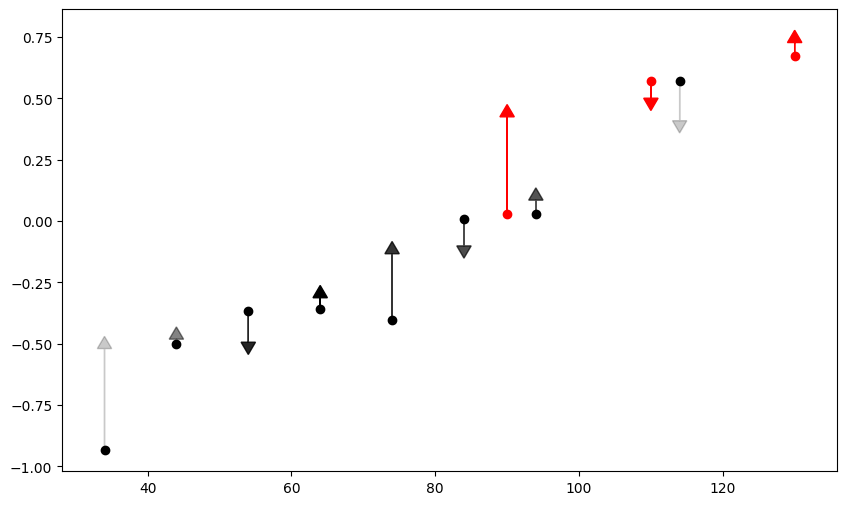

In [42]:
f = fancyscatter(wgptnames[0], wgptnames[1], wgptnames[2], 'wgpt', wgs)
plt.savefig("webgpt.pdf", format="pdf", bbox_inches="tight")

In [38]:
def difference_vis(x, ry, by):
    plt.figure(figsize=(10, 6))
    
    # Calculate the differences
    differences = [ry[i] - by[i] for i in range(len(x))]
    
    # Plotting the bars
    colors = ['red' if diff > 0 else 'blue' for diff in differences]
    plt.bar(x, differences, color=colors, edgecolor='black')

    # Setting the labels, title, etc.
    plt.axhline(0, color='black',linewidth=0.5)  # Add a horizontal line at y=0 for clarity
    plt.title("Difference between Red and Blue (Red up, Blue down)")
    plt.xlabel("X-values")
    plt.ylabel("Difference (Red - Blue)")
    plt.show()

In [59]:
f = fancyscatter(rlcdnames[0], rlcdnames[1], rlcdnames[2], 'rlcd', rlcds)
plt.savefig("rlcdarrows.pdf", format="pdf", bbox_inches="tight")

AttributeError: 'DataFrame' object has no attribute 'rewards'

0.480646136875455
0.37575687796765284


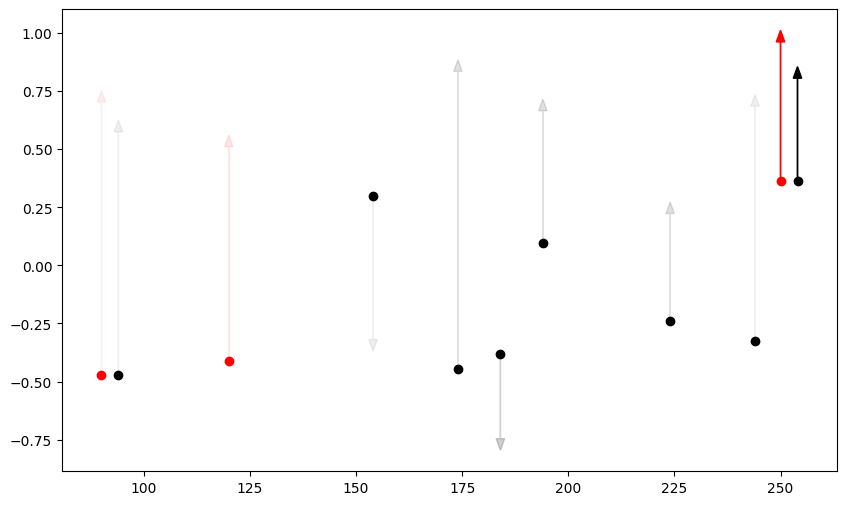

In [195]:
f = fancyscatter(stacknames[0], stacknames[1], stacknames[2], 'stack', stacks)
plt.savefig("stackarrows.pdf", format="pdf", bbox_inches="tight")